Importando as bibliotecas necessárias:

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds

Carregar o Dataset Cats vs Dogs do TensorFlow :

In [6]:
# Carregar o dataset Cats vs Dogs
dataset_name = "cats_vs_dogs"
(ds_train, ds_val), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],  # 80% para treino e 20% para validação
    with_info=True,
    as_supervised=True,  # Retorna tuplas (imagem, label)
)

# Exibir informações do dataset
print("Informações do dataset:")
print(ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.VVLL7K_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Informações do dataset:
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpb48nahzatfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-

Pré-Processamento para atender o padrão do modelo ResNet50v2 :

In [7]:
# Função de pré-processamento c
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Redimensionar para 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalizar para [0, 1]
    return image, label

# Carregar novamente o dataset
dataset_name = "cats_vs_dogs"
(ds_train, ds_val), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],  # 80% treino, 20% validação
    as_supervised=True,  # Retorna tuplas (imagem, label)
    with_info=True
)

# Aplicar o pré-processamento
batch_size = 32
ds_train = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Carregando e Configurando o modelo ResNet50V2 :

In [8]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Carregar o modelo base pré-treinado (sem a top layer)
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base
base_model.trainable = False

# Adicionar camadas finais específicas para gatos e cachorros
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduz a dimensionalidade
x = Dense(128, activation="relu")(x)  # Camada densa com 128 unidades e ReLU
output = Dense(1, activation="sigmoid")(x)  # Camada final binária (sigmoid para 2 classes)

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilar o modelo
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Resumo do modelo
model.summary()


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Treinando o modelo com 5 épocas:

In [9]:
# Treinamento do modelo
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=5  # Ajuste o número de épocas conforme necessário
)


Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 109ms/step - accuracy: 0.9713 - loss: 0.0755 - val_accuracy: 0.9845 - val_loss: 0.0420
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 63s 89ms/step - accuracy: 0.9889 - loss: 0.0299 - val_accuracy: 0.9847 - val_loss: 0.0438
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 90ms/step - accuracy: 0.9947 - loss: 0.0184 - val_accuracy: 0.9811 - val_loss: 0.0622
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9957 - loss: 0.0145 - val_accuracy: 0.9826 - val_loss: 0.0665
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9819 - val_loss: 0.0653


Análise de Desempenho do Modelo:

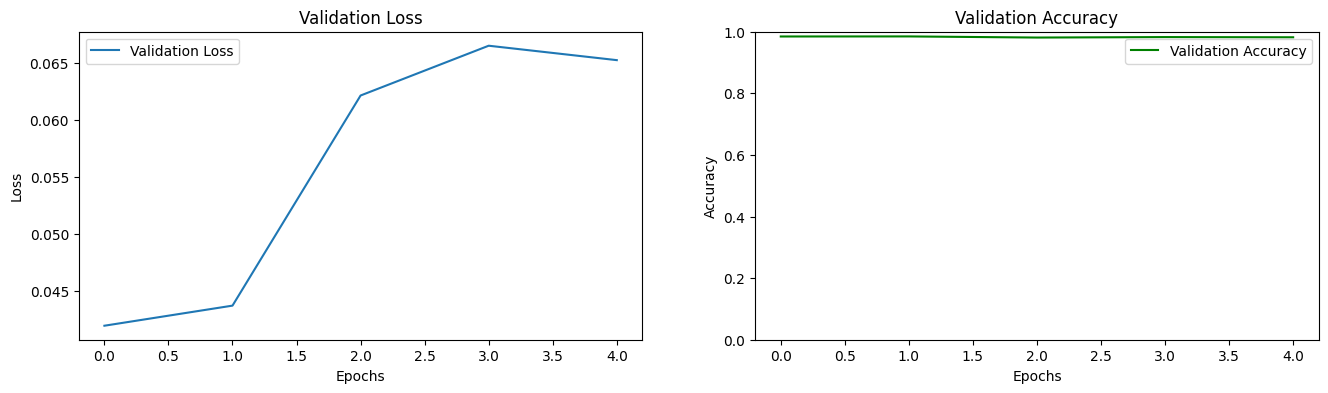

In [10]:
# Criar uma figura com subplots lado a lado
fig = plt.figure(figsize=(16, 4))

# Plotando a perda de validação
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"], label="Validation Loss")
ax.set_title("Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

# Plotando a acurácia de validação
ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"], label="Validation Accuracy", color="green")
ax2.set_title("Validation Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

# Exibindo os gráficos
plt.show()

Testando com uma imagem de Cachorro (aisha.jpg):

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


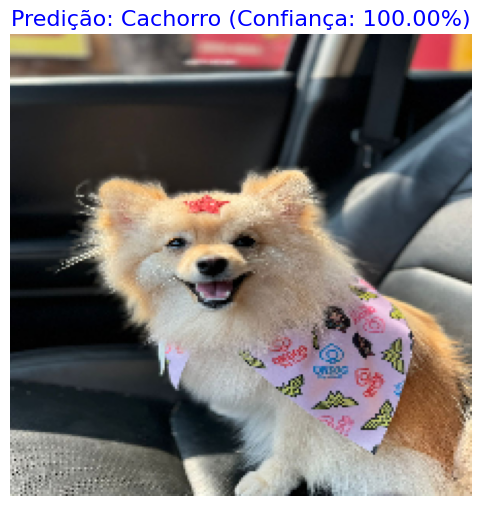

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Caminho para a imagem externa
image_path = "../images/aisha.jpg"

# Função para carregar e pré-processar a imagem
def preprocess_image(image_path, target_size=(224, 224)):
    # Carregar a imagem e redimensionar para o tamanho esperado pelo modelo
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)  # Converter para array NumPy
    image_array = image_array / 255.0  # Normalizar para [0, 1]
    return image_array, image

# Pré-processar a imagem
image_array, original_image = preprocess_image(image_path)

# Adicionar dimensão para representar o batch
input_tensor = np.expand_dims(image_array, axis=0)  # (1, 224, 224, 3)

# Fazer a previsão
predicted_prob = model.predict(input_tensor)[0][0]  # Pegar a probabilidade de "gato"

# Determinar a classe com base na probabilidade
predicted_class = "Cachorro" if predicted_prob > 0.5 else "Gato"  # Inverter a lógica
confidence = f"{predicted_prob * 100:.2f}%" if predicted_prob > 0.5 else f"{(1 - predicted_prob) * 100:.2f}%"

# Exibir a imagem com o resultado
plt.figure(figsize=(8, 6))
plt.imshow(original_image)
plt.title(f"Predição: {predicted_class} (Confiança: {confidence})", fontsize=16, color="blue")
plt.axis("off")
plt.show()


In [12]:
model.save("models/resnet50v2_model.h5")
